 ## Deep Learning Meets Hyperspectral Image Analysis

#### ABSTRACT
For our deep learning project, we present the recreation of one algorithm from the paper Deep-learning-based regression model and hyperspectral imaging for rapid detection of nitrogen concentration in oilseed rape (Brassica napus L.) leaf. 
We will present:
- First, a recreation of SAE model.
- Next, a recreation of SAE hyperparameters optimization. 
- Finally, a predication of nitrogen concentration which compares to results in the paper. 

In order to gain additional computing resource, we extended the experiments to Amazon Web Services Elastic Compute Cloud (EC2).

An in depth discussion of our recreation and additional experiments follows.



####  INTRODUCTION
The authors of the paper present a sevral algorithms that generates predictions for nitrogen concentration in oilseed rape leaf: PLS, LS-SVM, SAE- FNN (with different units of last layer). The SAE algorithm works by first training and tuning a neural network using a specific hyperparameters, fine tuning and evaluated over a test dataset. In the paper, the authors test the algorithm against several other algorithms, including PLS and LS-SVM, and compare the performance of with these algorithms across multiple different SAE-FNN models who depends in last layer values. In this report, we examine and attempt to reproduce several of the results given in the paper. We focus on one concrete result, that SEA-FNN10 achieved better results than those yielded by PLS, LS-SVM and other SEA-FNN models.

### OVERVIEW

#### REPRODUCTION GOALS
Our reproduction of SAE- FNN10 attempts to determine several things.
First, we simply attempt to recreate the results of the paper, in which the authors found that SAE-FNN10 outperformed other models. Second, we hope to learn more about the extent to which these results are the result. Finally, we add an additional task, to learn about how to use EC2.


####  REPRODUCTION SETUPS

In order to both reproduce the paper results and extend our knowledge, our reproduction setup used a Jupyter notebook using EC2 Instance type t2.xlarge with Ubuntu environment.

Our reproduction is based off of code provided by the authors of the paper, which can be found at https://www.sciencedirect.com/science/article/abs/pii/S0169743917306780#ec-research-data. Notably, the authors did not provide any of their code to their optimization and tuning. Accordingly, we had to write scripts to optimize and tune SAE ourselves based on the information provided in the paper. As a result, we had to modify the code base some allow us to faithfully reproduce the results in the paper. Our changes to their code base can be found below.

### Workflow
1. Import libraries.
2. Data loading and splitting.
3. Data visualization.
4. Keras sequential Model defintion.
5. Hyperparameters optimization.    
6. Prediction.
7. Summary and conclusion.




 #### IMPORT LIBRARIES

Core libraries for data processing 

In [65]:
import numpy as np
from numpy.core.umath_tests import inner1d
import pandas as pd
from pandas.core import datetools
import gzip
import time

Visualization libraries

In [66]:
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

Statistics tools

In [67]:
from sklearn.model_selection import train_test_split
import sys
from sklearn.metrics import mean_squared_error, r2_score
import random
random.seed(100) # for reproducibility
def rmse(predictions, targets): #RMSE function for model evaluation
    return np.sqrt(((predictions - targets) ** 2).mean())

Deep learning tools

In [68]:
# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense,Dropout
from keras.models import Model, Sequential, save_model, load_model
from keras.callbacks import CSVLogger,ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

Hyperparameters tuning

In [69]:

import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from talos.utils.gpu_utils import multi_gpu
from talos.utils.gpu_utils import force_cpu
sys.path.insert(0, '/home/ubuntu/talos/')
import wrangle as wr


####  DATA LOADING
For each sample-nitrogen concentration, spectral data in the
range of 380–1030 nm wavelength with 512 bands of each pixel were taken.
As we mention before we modified the base code and the data in order to preforme hyperparameter tuning. Therefore, we combined validation and train set into one data set.
The next step was to split to train (80%) and test (20%) sets. Tuning parameters preformed with Talos package, as a result, we didn't use validation set.



In [70]:
train_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_train.pkl.gz"   #train dataset 
validation_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_val.pkl.gz"#validation dataset        

In [71]:
with gzip.open(train_dataset, 'rb') as f:
            train_set1, valid_set1 = pickle.load(f)
with gzip.open(validation_dataset, 'rb') as f:
            train_set2, valid_set2= pickle.load(f)
X=np.concatenate((train_set1[0],train_set2[0],valid_set1[0],valid_set2[0]))# wavelength
y=np.concatenate((train_set1[1],train_set2[1],valid_set1[1],valid_set2[1]))# N concetration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True )

#### DATA VISUALIZATION

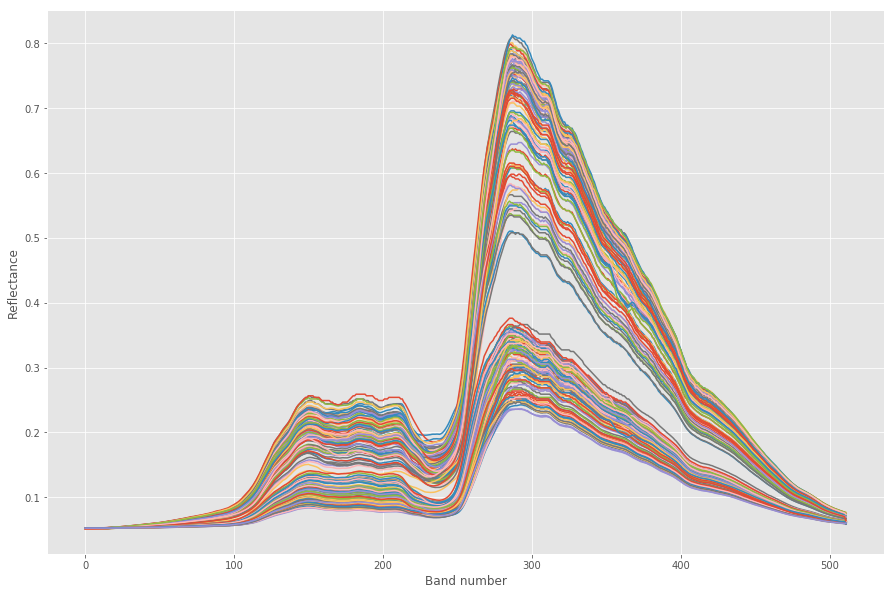

In [72]:
data = pd.read_csv("/home/ubuntu/SAE-FNN_Code_Data/data/Meanspectra.csv") #Mean spectra for each sample 
y_mean=data.iloc[:, 2]
X_mean=data.iloc[:, 3:]
band=range(512)
# Plot spectra
plt.figure(figsize=(15,10))
with plt.style.context(('ggplot')):
    plt.plot(band, X_mean.T)
    plt.xlabel('Band number')
    plt.ylabel('Reflectance')    
plt.show()

 Notice that region of bands 1-120, have moderate change while in the region of bands 250-512 have drastic change of reflectance.
 In addition, in region 250- 300 there are significant difference between each band.



####  KERAS SEQUENTIAL MODEL DEFINTION 

##### 1. SAE
- The sequential model is a linear stack of layers.
- we create a sequential model by calling the keras_model_sequential() function then a series of layer functions.
- Keras objects are modified in place which is why it’s not necessary for model to be assigned back to after the layers are added.
- Therefore, we can claim that SAE represent unsupervised learning. 
- The model needs to know what input shape (input_shape ) it should expect. For this reason, the first layer in a sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape.
- Before training a model, we need to configure the learning process, which is done via the compile() function. It receives three arguments:
    1. An optimizer. 
    2. A loss function.
    3. A list of metrics.
    

Notation as mentioned in the paper:

- Input and output layer of d units.
- Hidden layer of h units.
- Activation function- f().
- First the algorithm maps the input $ x\in R^{d}$ to the hidden layer and produces the latent activity $ y\in R^{h}$ which is called "encoding".
- Then $y$ is mapped back to an output layer that has the same size of the input layer, which is calles "decoding".
- The reconstructed values are denoted as $ z\in R^{d}$.
- These to stepd can be formulated as:

   $ y=f(w_{y}x+b_{y}), $
   $ z=f(w_{z}y+b_{z}) $
- Where $w_{y}$ is the input-to-hidden weight matrix.
- $w_{z}$ is the hidden-to-output weight matrix.
- $b_{y}$ and $b_{z}$ denote the bias of hidden and output units.
- The goal of learning is to minimize the "error" between input and output, which are denoted as: $argmin_{W,b_{y},b_{z}}[c(x,z)]$ where $ w_{y}={w}'_{z}=W$

##### 2. FNN
- We used SAE to extract deep spectral features from hyperspectral image, and then these features were used as input data for FNN to predict N concentration.
- Therefore, we can claim that FNN represent supervised learning. 
- Keras models are trained on R matrices or higher dimensional arrays of input data and labels. For training a model, we will use the fit() function.
- For FNN no activation function is used for the output layer of FNN network because itis a regression problem.
- Output of FNN is a single unit denoted as(Notation as mentioned in the paper): 
 $\hat{y}=w_{l}y_{l}+b_{l}$
- $\hat{y}$ is the output numerical value.
- $w_{l}$ is the weight matrix.
- $b_{l}$ is the bias of output unit.
- $y_{l}$ is the outputsof the last encoding layer.


In [73]:
# input: train (70%) and validation (30%) data with grid of paramaters (p)
# output: compiled model and model's data
def model_opti(x_train, y_train, x_val, y_val, params):
    
    #model format
    model = Sequential()
    
    #input layer
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    #this line is used to convey the fact that we wish to tune the activation 
                    #function parameter and find the best fit among 
                    activation=params['activation'],
                    #this line is used to convey the fact that we wish to tune the 
                    #kernel initializer parameter and find the best fit among 
                    kernel_initializer=params['kernel_initializer']))  
    #adding more layers
    #this line is used to convey the fact that we wish to tune the value of the keep probability of 
    #Dropout and find the best fit among the range of real numbers between 0 and 1.(=0)
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    #compiling the model
    #we declare the loss function and the optimizer
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc', fmeasure_acc])
    
    #fitting the model on training data
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=1)


    return history, model

#### HYPERPARAMETERS OPTIMIZATION

##### Tuning parameters:

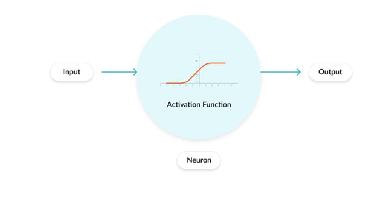

In [74]:
img=mpimg.imread('1.jpg')
plt.imshow(img)
im = Image.open("1.jpg")
im.rotate(45).show()
plt.axis('off')
plt.show(im)

- hidden_layers: Layer between input layers and output layers, where artificial neurons take in a set of weighted inputs and produce an output through an activation function.
- batch_size: Number of patterns shown to the network before the weight matrix is updated. If batch size is less, patterns would be less repeating and hence the weights would be all over the place and convergence would become difficult. If batch size is high learning would become slow as only after many iterations will the batch size change.
- epochs: The number of epochs is the number of times the entire training data is shown to the model. It plays an important role in how well does the model fit on the train data. High number of epochs may overfit to the data and may have generalization problems on the test and validation set, also they could cause vanishing and exploding gradient problems.





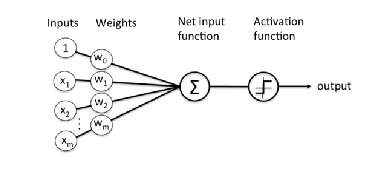

In [75]:
img=mpimg.imread('2.jpg')
plt.imshow(img)
im = Image.open("2.jpg")
im.rotate(45).show()
plt.axis('off')
plt.show(im)

- dropout: The keep-probability of the Dropout layer.
- kernel initializer:  Doesn’t play a very big role but still it is preferred to use normal/uniform initialization while using ReLUs/eLUs.
- optimizer: It is the algorithm used by the model to update weights of every layer after every iteration. 
- losses: we seek to minimize the error. As such, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function.

In order to "sense" the best parameters we changed the grid range couple of times until we got this practical grid.

presumption that was used: the more epochs the better, until getting overfitting. Hence, we used a small value of epochs in the tuning section, in the final model we used larger value.


In [ ]:
# set the parameter space
p =  {'first_neuron':[7,8,9,10,20],
     'hidden_layers':[3,4,5,10],
     'batch_size': [128],
     'epochs': [20],
     'dropout': [0.5,0.6,0.7,0.8],
     'kernel_initializer': ['normal','uniform'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu,relu],
     'last_activation': ['elu','relu']
}

##### Talos

As we presented earlier, when designing the architecture for an artificial neural network, there exist a variety of parameters that can be tuned.

Just like we have GridSearchCV for hyperparameter optimization within scikit-learn models like Decision Trees, Talos can be applied on Keras models. Talos works similarly to GridSearchCV, by testing all possible combinations of those parameters we have introduced, and chooses the best model, based on what parameter we have asked it to either optimize or reduce (MSE in our case).

Optimize or reduce preformed by cross validation K-fold method. As mentioned earlier, that's the reason why we didn't split the data to validation set and just used training set.



In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with all combinations.
start = time.time()
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p,
            dataset_name='talos tutorial',
            experiment_no='1')

end = time.time()
during=end - start
















  0%|          | 0/640 [00:00<?, ?it/s]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 21us/step - loss: 2.9466 - acc: 0.0000e+00 - fmeasure_acc: 1.0046 - val_loss: 0.7208 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 2.0155 - acc: 0.0000e+00 - fmeasure_acc: 1.0356 - val_loss: 0.4704 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.5068 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4135 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.0622 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7322 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1940 - val_acc: 0.0000e+00 - 















  0%|          | 1/640 [00:16<2:58:04, 16.72s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.9005 - acc: 0.0000e+00 - fmeasure_acc: 1.0013 - val_loss: 0.0529 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5567 - acc: 0.0000e+00 - fmeasure_acc: 1.0001 - val_loss: 0.0303 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4666 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3731 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0277 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2910 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.0000e+00 - 















  0%|          | 2/640 [00:33<2:58:15, 16.76s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.2941 - acc: 0.0000e+00 - fmeasure_acc: 1.0047 - val_loss: 0.1457 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7679 - acc: 0.0000e+00 - fmeasure_acc: 1.0010 - val_loss: 0.0750 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6341 - acc: 0.0000e+00 - fmeasure_acc: 1.0002 - val_loss: 0.0586 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4976 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.3773 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.0000e+00 - 















  0%|          | 3/640 [00:49<2:54:34, 16.44s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.2006 - acc: 0.0000e+00 - fmeasure_acc: 1.0026 - val_loss: 0.0823 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7733 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0793 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6170 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0699 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4724 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3449 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.0000e+00 - 















  1%|          | 4/640 [01:06<2:56:10, 16.62s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.1962 - acc: 0.0000e+00 - fmeasure_acc: 1.0044 - val_loss: 0.3550 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4201 - acc: 0.0000e+00 - fmeasure_acc: 1.0143 - val_loss: 0.2801 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1065 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1601 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8082 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1502 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5759 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1048 - val_acc: 0.0000e+00 - 















  1%|          | 5/640 [01:22<2:53:22, 16.38s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 2.1660 - acc: 0.0000e+00 - fmeasure_acc: 0.9838 - val_loss: 0.3906 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.4350 - acc: 0.0000e+00 - fmeasure_acc: 1.0269 - val_loss: 0.2968 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.0912 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2041 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8297 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1726 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5855 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1110 - val_acc: 0.0000e+00 - 















  1%|          | 6/640 [01:39<2:54:53, 16.55s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 16us/step - loss: 2.9290 - acc: 0.0000e+00 - fmeasure_acc: 1.0098 - val_loss: 0.4620 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5509 - acc: 0.0000e+00 - fmeasure_acc: 1.0225 - val_loss: 0.2728 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2485 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2184 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9615 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1981 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7055 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1204 - val_acc: 0.0000e+00 - 















  1%|          | 7/640 [01:54<2:50:24, 16.15s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.5418 - acc: 0.0000e+00 - fmeasure_acc: 0.9988 - val_loss: 0.1226 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8650 - acc: 0.0000e+00 - fmeasure_acc: 1.0021 - val_loss: 0.0949 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7084 - acc: 0.0000e+00 - fmeasure_acc: 1.0005 - val_loss: 0.0628 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5620 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0710 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4291 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.0000e+00 - 















  1%|▏         | 8/640 [02:10<2:49:08, 16.06s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.4212 - acc: 0.0000e+00 - fmeasure_acc: 0.9999 - val_loss: 0.1641 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9470 - acc: 0.0000e+00 - fmeasure_acc: 1.0040 - val_loss: 0.1162 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7577 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.1513 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5778 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4248 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.0000e+00 - 















  1%|▏         | 9/640 [02:27<2:51:47, 16.34s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.3196 - acc: 0.0000e+00 - fmeasure_acc: 1.0263 - val_loss: 1.7461 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.0682 - acc: 0.0000e+00 - fmeasure_acc: 1.0770 - val_loss: 1.2427 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2062 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9494 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5296 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6387 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0116 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4210 - val_acc: 0.0000e+00 - 















  2%|▏         | 10/640 [02:43<2:50:12, 16.21s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 2.1650 - acc: 0.0000e+00 - fmeasure_acc: 0.9865 - val_loss: 0.3096 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.4170 - acc: 0.0000e+00 - fmeasure_acc: 1.0261 - val_loss: 0.2626 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1062 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2203 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8179 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1305 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5785 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.0000e+00 - 















  2%|▏         | 11/640 [02:59<2:51:49, 16.39s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.2719 - acc: 0.0000e+00 - fmeasure_acc: 1.0056 - val_loss: 0.3457 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4306 - acc: 0.0000e+00 - fmeasure_acc: 1.0151 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0996 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1623 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8177 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1396 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5842 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0815 - val_acc: 0.0000e+00 - 















  2%|▏         | 12/640 [03:15<2:50:15, 16.27s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 5.2129 - acc: 0.0000e+00 - fmeasure_acc: 1.0438 - val_loss: 2.5916 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.7065 - acc: 0.0000e+00 - fmeasure_acc: 1.1325 - val_loss: 1.8819 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.6640 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.3359 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8338 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9055 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2128 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5744 - val_acc: 0.0000e+00 - 















  2%|▏         | 13/640 [03:31<2:48:35, 16.13s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.2204 - acc: 0.0000e+00 - fmeasure_acc: 1.0014 - val_loss: 0.4268 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4205 - acc: 0.0000e+00 - fmeasure_acc: 1.0143 - val_loss: 0.2923 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1011 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2178 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7993 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1672 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5678 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.0000e+00 - 















  2%|▏         | 14/640 [03:47<2:47:07, 16.02s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.0447 - acc: 0.0000e+00 - fmeasure_acc: 1.0074 - val_loss: 0.3168 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3094 - acc: 0.0000e+00 - fmeasure_acc: 1.0102 - val_loss: 0.2334 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0135 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7520 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5319 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.0000e+00 - 















  2%|▏         | 15/640 [04:03<2:46:41, 16.00s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 6.5932 - acc: 0.0000e+00 - fmeasure_acc: 1.1402 - val_loss: 4.4474 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 4.7532 - acc: 0.0000e+00 - fmeasure_acc: 1.1333 - val_loss: 3.2017 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3634 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 2.2247 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2995 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.4782 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4921 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9353 - val_acc: 0.0000e+00 - 















  2%|▎         | 16/640 [04:19<2:46:17, 15.99s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.2486 - acc: 0.0000e+00 - fmeasure_acc: 0.9812 - val_loss: 0.8649 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2413 - acc: 0.0000e+00 - fmeasure_acc: 1.0800 - val_loss: 0.6605 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6620 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4936 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1854 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3457 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8090 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2080 - val_acc: 0.0000e+00 - 















  3%|▎         | 17/640 [04:34<2:44:58, 15.89s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.7864 - acc: 0.0000e+00 - fmeasure_acc: 1.0147 - val_loss: 1.4370 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.7169 - acc: 0.0000e+00 - fmeasure_acc: 1.0675 - val_loss: 0.9402 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.9687 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7042 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3548 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4793 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8945 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3302 - val_acc: 0.0000e+00 - 















  3%|▎         | 18/640 [04:50<2:44:20, 15.85s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.3513 - acc: 0.0000e+00 - fmeasure_acc: 1.0196 - val_loss: 1.8443 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.0999 - acc: 0.0000e+00 - fmeasure_acc: 1.0790 - val_loss: 1.3651 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2201 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.0324 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5332 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5661 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0062 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4357 - val_acc: 0.0000e+00 - 















  3%|▎         | 19/640 [05:06<2:42:50, 15.73s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.3490 - acc: 0.0000e+00 - fmeasure_acc: 1.0058 - val_loss: 0.3614 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4379 - acc: 0.0000e+00 - fmeasure_acc: 1.0157 - val_loss: 0.2915 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1128 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2630 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8260 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1578 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5970 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.0000e+00 - 















  3%|▎         | 20/640 [05:22<2:43:22, 15.81s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.2656 - acc: 0.0000e+00 - fmeasure_acc: 0.9789 - val_loss: 0.8667 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2112 - acc: 0.0000e+00 - fmeasure_acc: 1.0780 - val_loss: 0.6770 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6551 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4480 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1907 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3219 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7984 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2298 - val_acc: 0.0000e+00 - 















  3%|▎         | 21/640 [05:38<2:43:29, 15.85s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 2.4844 - acc: 0.0000e+00 - fmeasure_acc: 0.9895 - val_loss: 0.5193 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.6946 - acc: 0.0000e+00 - fmeasure_acc: 1.0413 - val_loss: 0.3807 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.2808 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2633 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9268 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2003 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6413 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.0000e+00 - 















  3%|▎         | 22/640 [05:54<2:46:11, 16.13s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.2628 - acc: 0.0000e+00 - fmeasure_acc: 1.0080 - val_loss: 0.0930 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7041 - acc: 0.0000e+00 - fmeasure_acc: 1.0005 - val_loss: 0.0846 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5818 - acc: 0.0000e+00 - fmeasure_acc: 1.0002 - val_loss: 0.0542 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4723 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.3648 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.0000e+00 - 















  4%|▎         | 23/640 [06:10<2:45:20, 16.08s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.2593 - acc: 0.0000e+00 - fmeasure_acc: 1.0049 - val_loss: 0.1177 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7844 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0958 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6400 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4981 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0745 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3736 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.0000e+00 - 















  4%|▍         | 24/640 [06:27<2:48:08, 16.38s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.1764 - acc: 0.0000e+00 - fmeasure_acc: 1.0107 - val_loss: 0.8133 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.1533 - acc: 0.0000e+00 - fmeasure_acc: 1.0400 - val_loss: 0.6310 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6040 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4671 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1348 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3271 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7703 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2140 - val_acc: 0.0000e+00 - 















  4%|▍         | 25/640 [06:43<2:45:07, 16.11s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 4.9227 - acc: 0.0000e+00 - fmeasure_acc: 1.0324 - val_loss: 2.3127 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 3.4958 - acc: 0.0000e+00 - fmeasure_acc: 1.1004 - val_loss: 1.6958 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 2.5118 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.1032 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.7364 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7957 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1391 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5272 - val_acc: 0.0000e+00 - 















  4%|▍         | 26/640 [07:00<2:47:07, 16.33s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.7871 - acc: 0.0000e+00 - fmeasure_acc: 0.9976 - val_loss: 0.2233 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.2019 - acc: 0.0000e+00 - fmeasure_acc: 1.0137 - val_loss: 0.1569 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9327 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1400 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6913 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0829 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4911 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0889 - val_acc: 0.0000e+00 - 















  4%|▍         | 27/640 [07:17<2:48:25, 16.48s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.6307 - acc: 0.0000e+00 - fmeasure_acc: 0.9996 - val_loss: 0.1918 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1306 - acc: 0.0000e+00 - fmeasure_acc: 1.0066 - val_loss: 0.1892 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8706 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1548 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6389 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4531 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.0000e+00 - 















  4%|▍         | 28/640 [07:33<2:48:44, 16.54s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.7328 - acc: 0.0000e+00 - fmeasure_acc: 1.0049 - val_loss: 0.2087 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9617 - acc: 0.0000e+00 - fmeasure_acc: 1.0029 - val_loss: 0.1422 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7897 - acc: 0.0000e+00 - fmeasure_acc: 1.0002 - val_loss: 0.0892 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6259 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4589 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.0000e+00 - 















  5%|▍         | 29/640 [07:49<2:45:28, 16.25s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.6823 - acc: 0.0000e+00 - fmeasure_acc: 0.9918 - val_loss: 0.6100 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.8658 - acc: 0.0000e+00 - fmeasure_acc: 1.0336 - val_loss: 0.4863 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.3779 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3896 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9818 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6763 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1516 - val_acc: 0.0000e+00 - 















  5%|▍         | 30/640 [08:05<2:45:52, 16.32s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.7642 - acc: 0.0000e+00 - fmeasure_acc: 1.0025 - val_loss: 0.0366 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3969 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3482 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2955 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2425 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.0000e+00 - 















  5%|▍         | 31/640 [08:22<2:46:26, 16.40s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.8703 - acc: 0.0000e+00 - fmeasure_acc: 1.0157 - val_loss: 1.3523 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.7488 - acc: 0.0000e+00 - fmeasure_acc: 1.0725 - val_loss: 1.0730 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.9867 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7691 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3816 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5279 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9158 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3310 - val_acc: 0.0000e+00 - 















  5%|▌         | 32/640 [08:38<2:44:05, 16.19s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 5.1577 - acc: 0.0000e+00 - fmeasure_acc: 1.0552 - val_loss: 2.5604 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.6814 - acc: 0.0000e+00 - fmeasure_acc: 1.1237 - val_loss: 1.8732 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.6346 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.3161 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8213 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.8914 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1942 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5713 - val_acc: 0.0000e+00 - 















  5%|▌         | 33/640 [08:54<2:43:11, 16.13s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.4022 - acc: 0.0000e+00 - fmeasure_acc: 1.0068 - val_loss: 0.1212 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7774 - acc: 0.0000e+00 - fmeasure_acc: 1.0009 - val_loss: 0.0817 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6487 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0763 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5140 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4020 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.0000e+00 - 















  5%|▌         | 34/640 [09:09<2:41:40, 16.01s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.5714 - acc: 0.0000e+00 - fmeasure_acc: 1.0025 - val_loss: 0.4852 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5364 - acc: 0.0000e+00 - fmeasure_acc: 1.0195 - val_loss: 0.3200 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1915 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2214 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8977 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6313 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1155 - val_acc: 0.0000e+00 - 















  5%|▌         | 35/640 [09:25<2:39:57, 15.86s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.3839 - acc: 0.0000e+00 - fmeasure_acc: 1.0016 - val_loss: 0.1108 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7124 - acc: 0.0000e+00 - fmeasure_acc: 1.0003 - val_loss: 0.0625 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5973 - acc: 0.0000e+00 - fmeasure_acc: 1.0003 - val_loss: 0.0539 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4861 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.3837 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.0000e+00 - 















  6%|▌         | 36/640 [09:41<2:40:18, 15.92s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.2169 - acc: 0.0000e+00 - fmeasure_acc: 1.0038 - val_loss: 0.1189 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7162 - acc: 0.0000e+00 - fmeasure_acc: 1.0005 - val_loss: 0.0750 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5975 - acc: 0.0000e+00 - fmeasure_acc: 1.0002 - val_loss: 0.0515 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4743 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.3698 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.0000e+00 - 















  6%|▌         | 37/640 [09:57<2:40:01, 15.92s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.2976 - acc: 0.0000e+00 - fmeasure_acc: 1.0268 - val_loss: 1.7714 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.0861 - acc: 0.0000e+00 - fmeasure_acc: 1.0745 - val_loss: 1.4631 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.1979 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9161 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5121 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9961 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3874 - val_acc: 0.0000e+00 - 















  6%|▌         | 38/640 [10:13<2:39:27, 15.89s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 6.6393 - acc: 0.0000e+00 - fmeasure_acc: 1.1265 - val_loss: 4.4669 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 4.7712 - acc: 0.0000e+00 - fmeasure_acc: 1.1415 - val_loss: 3.2230 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3894 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 2.2454 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3101 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.4862 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5006 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9448 - val_acc: 0.0000e+00 - 















  6%|▌         | 39/640 [10:29<2:39:08, 15.89s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.1241 - acc: 0.0000e+00 - fmeasure_acc: 0.9902 - val_loss: 0.8069 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.1812 - acc: 0.0000e+00 - fmeasure_acc: 1.0597 - val_loss: 0.6143 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6176 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4107 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1385 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3397 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7687 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1967 - val_acc: 0.0000e+00 - 















  6%|▋         | 40/640 [10:44<2:38:34, 15.86s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.2583 - acc: 0.0000e+00 - fmeasure_acc: 1.0055 - val_loss: 1.0959 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3444 - acc: 0.0000e+00 - fmeasure_acc: 1.0505 - val_loss: 0.7906 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6792 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4694 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1747 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3431 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7843 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2337 - val_acc: 0.0000e+00 - 















  6%|▋         | 41/640 [11:00<2:38:09, 15.84s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.4868 - acc: 0.0000e+00 - fmeasure_acc: 1.0128 - val_loss: 0.3873 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4478 - acc: 0.0000e+00 - fmeasure_acc: 1.0166 - val_loss: 0.2571 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1494 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2011 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8668 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1695 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6321 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1087 - val_acc: 0.0000e+00 - 















  7%|▋         | 42/640 [11:16<2:37:08, 15.77s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.5972 - acc: 0.0000e+00 - fmeasure_acc: 0.9801 - val_loss: 0.4993 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.7303 - acc: 0.0000e+00 - fmeasure_acc: 1.0467 - val_loss: 0.3842 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3166 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2688 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9543 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6683 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.0000e+00 - 















  7%|▋         | 43/640 [11:32<2:36:50, 15.76s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 3.4593 - acc: 0.0000e+00 - fmeasure_acc: 1.0138 - val_loss: 1.0845 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 15us/step - loss: 2.4781 - acc: 0.0000e+00 - fmeasure_acc: 1.0481 - val_loss: 0.9167 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.7883 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6501 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 15us/step - loss: 1.2438 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3367 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 15us/step - loss: 0.8121 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2361 - val_acc: 0.0000e+00 - 















  7%|▋         | 44/640 [11:49<2:41:29, 16.26s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.9242 - acc: 0.0000e+00 - fmeasure_acc: 1.0059 - val_loss: 1.4054 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.7493 - acc: 0.0000e+00 - fmeasure_acc: 1.0767 - val_loss: 1.0236 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.0113 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.8374 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3897 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4976 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9266 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3393 - val_acc: 0.0000e+00 - 















  7%|▋         | 45/640 [12:05<2:39:22, 16.07s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.9365 - acc: 0.0000e+00 - fmeasure_acc: 1.0083 - val_loss: 0.7601 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.9968 - acc: 0.0000e+00 - fmeasure_acc: 1.0348 - val_loss: 0.6013 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4958 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4262 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0764 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7351 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1761 - val_acc: 0.0000e+00 - 















  7%|▋         | 46/640 [12:20<2:38:23, 16.00s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.6467 - acc: 0.0000e+00 - fmeasure_acc: 0.9843 - val_loss: 0.4287 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6319 - acc: 0.0000e+00 - fmeasure_acc: 1.0202 - val_loss: 0.3767 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.2197 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2483 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8810 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6005 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1187 - val_acc: 0.0000e+00 - 















  7%|▋         | 47/640 [12:37<2:38:31, 16.04s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.6170 - acc: 0.0000e+00 - fmeasure_acc: 1.0068 - val_loss: 1.8347 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 3.1761 - acc: 0.0000e+00 - fmeasure_acc: 1.1314 - val_loss: 1.3626 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3108 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9722 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6170 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6660 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.0812 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4357 - val_acc: 0.0000e+00 - 















  8%|▊         | 48/640 [12:53<2:38:24, 16.05s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.6992 - acc: 0.0000e+00 - fmeasure_acc: 1.0158 - val_loss: 0.1776 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8289 - acc: 0.0000e+00 - fmeasure_acc: 1.0020 - val_loss: 0.0763 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6882 - acc: 0.0000e+00 - fmeasure_acc: 1.0003 - val_loss: 0.0602 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5600 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0619 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4365 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.0000e+00 - 















  8%|▊         | 49/640 [13:08<2:36:42, 15.91s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 8.0404 - acc: 0.0000e+00 - fmeasure_acc: 1.2594 - val_loss: 6.8522 - val_acc: 0.0000e+00 - val_fmeasure_acc: 2.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 5.8418 - acc: 0.0000e+00 - fmeasure_acc: 1.1583 - val_loss: 4.9050 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 4.1172 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 3.3922 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.7924 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 2.2458 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8038 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.4066 - val_acc: 0.0000e+00 - 















  8%|▊         | 50/640 [13:24<2:36:40, 15.93s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.2662 - acc: 0.0000e+00 - fmeasure_acc: 1.0063 - val_loss: 0.3393 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1492 - acc: 0.0000e+00 - fmeasure_acc: 1.0082 - val_loss: 0.1444 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9230 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7217 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5447 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.0000e+00 - 















  8%|▊         | 51/640 [13:40<2:35:10, 15.81s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.3670 - acc: 0.0000e+00 - fmeasure_acc: 1.0046 - val_loss: 0.4352 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5386 - acc: 0.0000e+00 - fmeasure_acc: 1.0198 - val_loss: 0.2647 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1744 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2400 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8705 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1595 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6106 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.0000e+00 - 















  8%|▊         | 52/640 [13:55<2:34:41, 15.79s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.8808 - acc: 0.0000e+00 - fmeasure_acc: 1.0493 - val_loss: 2.4026 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.4805 - acc: 0.0000e+00 - fmeasure_acc: 1.0882 - val_loss: 1.6747 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.4716 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.2596 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6978 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7987 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1142 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5362 - val_acc: 0.0000e+00 - 















  8%|▊         | 53/640 [14:11<2:34:21, 15.78s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.1162 - acc: 0.0000e+00 - fmeasure_acc: 0.9886 - val_loss: 0.3641 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4197 - acc: 0.0000e+00 - fmeasure_acc: 1.0251 - val_loss: 0.3162 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0883 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1724 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7987 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1682 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5578 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.0000e+00 - 















  8%|▊         | 54/640 [14:27<2:33:34, 15.73s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.9410 - acc: 0.0000e+00 - fmeasure_acc: 0.9983 - val_loss: 0.3173 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.3689 - acc: 0.0000e+00 - fmeasure_acc: 1.0099 - val_loss: 0.2368 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.0032 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1586 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7079 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1988 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4889 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.0000e+00 - 















  9%|▊         | 55/640 [14:43<2:35:56, 15.99s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 6.6290 - acc: 0.0000e+00 - fmeasure_acc: 1.1273 - val_loss: 4.4654 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 4.7481 - acc: 0.0000e+00 - fmeasure_acc: 1.1394 - val_loss: 3.2176 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3740 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 2.2413 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3098 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.4935 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5045 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9444 - val_acc: 0.0000e+00 - 















  9%|▉         | 56/640 [14:59<2:35:27, 15.97s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.7097 - acc: 0.0000e+00 - fmeasure_acc: 1.0002 - val_loss: 0.0342 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3965 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3441 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0233 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2843 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2291 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.0000e+00 - 















  9%|▉         | 57/640 [15:16<2:37:29, 16.21s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.3932 - acc: 0.0000e+00 - fmeasure_acc: 1.0062 - val_loss: 0.1093 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7786 - acc: 0.0000e+00 - fmeasure_acc: 1.0008 - val_loss: 0.0840 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6344 - acc: 0.0000e+00 - fmeasure_acc: 1.0003 - val_loss: 0.0650 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5107 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.3942 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.0000e+00 - 















  9%|▉         | 58/640 [15:32<2:35:32, 16.03s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.3081 - acc: 0.0000e+00 - fmeasure_acc: 1.0109 - val_loss: 0.2956 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3254 - acc: 0.0000e+00 - fmeasure_acc: 1.0124 - val_loss: 0.2231 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0695 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1385 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8087 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1234 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5909 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1068 - val_acc: 0.0000e+00 - 















  9%|▉         | 59/640 [15:47<2:34:12, 15.93s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.8122 - acc: 0.0000e+00 - fmeasure_acc: 1.0012 - val_loss: 0.0306 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4021 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0286 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3548 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3060 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2524 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.0000e+00 - 















  9%|▉         | 60/640 [16:04<2:36:29, 16.19s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.9826 - acc: 0.0000e+00 - fmeasure_acc: 0.9904 - val_loss: 1.3399 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.7464 - acc: 0.0000e+00 - fmeasure_acc: 1.0951 - val_loss: 0.9884 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.0099 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7163 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4238 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4951 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9535 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3035 - val_acc: 0.0000e+00 - 















 10%|▉         | 61/640 [16:20<2:34:53, 16.05s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.7212 - acc: 0.0000e+00 - fmeasure_acc: 1.0259 - val_loss: 2.0746 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3313 - acc: 0.0000e+00 - fmeasure_acc: 1.1020 - val_loss: 1.5574 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.4110 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.1415 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6509 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7518 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1011 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4519 - val_acc: 0.0000e+00 - 















 10%|▉         | 62/640 [16:35<2:32:51, 15.87s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.8491 - acc: 0.0000e+00 - fmeasure_acc: 1.0490 - val_loss: 2.3910 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.4585 - acc: 0.0000e+00 - fmeasure_acc: 1.0906 - val_loss: 1.6049 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.4942 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.2020 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7168 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.8206 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1133 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5031 - val_acc: 0.0000e+00 - 















 10%|▉         | 63/640 [16:51<2:31:33, 15.76s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.4880 - acc: 0.0000e+00 - fmeasure_acc: 1.0019 - val_loss: 0.1479 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8564 - acc: 0.0000e+00 - fmeasure_acc: 1.0019 - val_loss: 0.0830 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7043 - acc: 0.0000e+00 - fmeasure_acc: 1.0005 - val_loss: 0.1075 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5553 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4199 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.0000e+00 - 















 10%|█         | 64/640 [17:06<2:30:14, 15.65s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.6634 - acc: 0.0000e+00 - fmeasure_acc: 1.0062 - val_loss: 0.1233 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7057 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0754 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6030 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0481 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5077 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0399 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4112 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.0000e+00 - 















 10%|█         | 65/640 [17:22<2:29:50, 15.64s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.7713 - acc: 0.0000e+00 - fmeasure_acc: 1.0092 - val_loss: 0.5029 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7007 - acc: 0.0000e+00 - fmeasure_acc: 1.0282 - val_loss: 0.3700 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3200 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3017 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9885 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6936 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1261 - val_acc: 0.0000e+00 - 















 10%|█         | 66/640 [17:38<2:29:41, 15.65s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.0858 - acc: 0.0000e+00 - fmeasure_acc: 0.9948 - val_loss: 0.7468 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.1704 - acc: 0.0000e+00 - fmeasure_acc: 1.0553 - val_loss: 0.5768 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5929 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4691 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1176 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3502 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7541 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1860 - val_acc: 0.0000e+00 - 















 10%|█         | 67/640 [17:53<2:29:33, 15.66s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.7288 - acc: 0.0000e+00 - fmeasure_acc: 1.0016 - val_loss: 0.2460 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1602 - acc: 0.0000e+00 - fmeasure_acc: 1.0042 - val_loss: 0.1865 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8844 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1203 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6547 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0824 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4632 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0726 - val_acc: 0.0000e+00 - 















 11%|█         | 68/640 [18:10<2:32:34, 16.00s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.7819 - acc: 0.0000e+00 - fmeasure_acc: 1.0056 - val_loss: 0.2537 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1801 - acc: 0.0000e+00 - fmeasure_acc: 1.0048 - val_loss: 0.1953 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9078 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1289 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6716 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1195 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4866 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.0000e+00 - 















 11%|█         | 69/640 [18:27<2:33:53, 16.17s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.0792 - acc: 0.0000e+00 - fmeasure_acc: 0.9961 - val_loss: 0.3263 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3162 - acc: 0.0000e+00 - fmeasure_acc: 1.0108 - val_loss: 0.2149 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0141 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1575 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7427 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1399 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5318 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0795 - val_acc: 0.0000e+00 - 















 11%|█         | 70/640 [18:42<2:31:53, 15.99s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.7844 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3974 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3519 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0231 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3005 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2508 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.0000e+00 - 















 11%|█         | 71/640 [18:59<2:33:36, 16.20s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 2.5684 - acc: 0.0000e+00 - fmeasure_acc: 0.9996 - val_loss: 0.5613 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.8045 - acc: 0.0000e+00 - fmeasure_acc: 1.0263 - val_loss: 0.4702 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.3155 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9178 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1863 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6251 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.0000e+00 - 















 11%|█▏        | 72/640 [19:16<2:34:37, 16.33s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.1653 - acc: 0.0000e+00 - fmeasure_acc: 1.0029 - val_loss: 0.3433 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2489 - acc: 0.0000e+00 - fmeasure_acc: 1.0112 - val_loss: 0.2326 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9823 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1521 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7455 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5397 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.0000e+00 - 















 11%|█▏        | 73/640 [19:31<2:32:20, 16.12s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - ETA: 0s - loss: 3.4020 - acc: 0.0000e+00 - fmeasure_acc: 0.98 - 1s 16us/step - loss: 3.3602 - acc: 0.0000e+00 - fmeasure_acc: 0.9946 - val_loss: 1.0551 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3626 - acc: 0.0000e+00 - fmeasure_acc: 1.0574 - val_loss: 0.7571 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7210 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5458 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2219 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3332 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8150 - acc: 0.0000e+00 - 















 12%|█▏        | 74/640 [19:46<2:29:19, 15.83s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 16us/step - loss: 3.2889 - acc: 0.0000e+00 - fmeasure_acc: 1.0157 - val_loss: 0.8297 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.1482 - acc: 0.0000e+00 - fmeasure_acc: 1.0414 - val_loss: 0.6439 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6159 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4491 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1600 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2877 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7947 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2118 - val_acc: 0.0000e+00 - 















 12%|█▏        | 75/640 [20:01<2:27:05, 15.62s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.2222 - acc: 0.0000e+00 - fmeasure_acc: 1.0045 - val_loss: 0.0738 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.7776 - acc: 0.0000e+00 - fmeasure_acc: 1.0004 - val_loss: 0.0782 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6238 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0759 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4830 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3520 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.0000e+00 - 















 12%|█▏        | 76/640 [20:19<2:31:01, 16.07s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.6204 - acc: 0.0000e+00 - fmeasure_acc: 1.0079 - val_loss: 1.8401 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.1751 - acc: 0.0000e+00 - fmeasure_acc: 1.1313 - val_loss: 1.3698 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3073 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9703 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6305 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6625 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0813 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.0000e+00 - 















 12%|█▏        | 77/640 [20:34<2:30:13, 16.01s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.6280 - acc: 0.0000e+00 - fmeasure_acc: 0.9750 - val_loss: 0.5383 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7310 - acc: 0.0000e+00 - fmeasure_acc: 1.0477 - val_loss: 0.3579 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3261 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3000 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9738 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2195 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6754 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1600 - val_acc: 0.0000e+00 - 















 12%|█▏        | 78/640 [20:50<2:29:31, 15.96s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.7091 - acc: 0.0000e+00 - fmeasure_acc: 1.0025 - val_loss: 0.1905 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1678 - acc: 0.0000e+00 - fmeasure_acc: 1.0046 - val_loss: 0.1850 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8965 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1495 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6595 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4645 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.0000e+00 - 















 12%|█▏        | 79/640 [21:07<2:31:55, 16.25s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.6950 - acc: 0.0000e+00 - fmeasure_acc: 1.0024 - val_loss: 0.1476 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0305 - acc: 0.0000e+00 - fmeasure_acc: 1.0049 - val_loss: 0.1668 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8162 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0997 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6137 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0880 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4476 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.0000e+00 - 















 12%|█▎        | 80/640 [21:23<2:30:40, 16.14s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 5.2886 - acc: 0.0000e+00 - fmeasure_acc: 1.0315 - val_loss: 2.5820 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.7156 - acc: 0.0000e+00 - fmeasure_acc: 1.1368 - val_loss: 1.8797 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.6746 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.3383 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8482 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.9040 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2235 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5830 - val_acc: 0.0000e+00 - 















 13%|█▎        | 81/640 [21:39<2:29:05, 16.00s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.6336 - acc: 0.0000e+00 - fmeasure_acc: 1.0084 - val_loss: 0.6240 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8516 - acc: 0.0000e+00 - fmeasure_acc: 1.0247 - val_loss: 0.4781 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.3753 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2683 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9682 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2326 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6574 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1625 - val_acc: 0.0000e+00 - 















 13%|█▎        | 82/640 [21:54<2:27:54, 15.90s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.8581 - acc: 0.0000e+00 - fmeasure_acc: 1.0463 - val_loss: 2.2667 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.4738 - acc: 0.0000e+00 - fmeasure_acc: 1.0925 - val_loss: 1.6647 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.4781 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.1175 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7105 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7802 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1284 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5003 - val_acc: 0.0000e+00 - 















 13%|█▎        | 83/640 [22:10<2:27:18, 15.87s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.2618 - acc: 0.0000e+00 - fmeasure_acc: 0.9747 - val_loss: 0.7691 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.2234 - acc: 0.0000e+00 - fmeasure_acc: 1.0659 - val_loss: 0.6357 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6460 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4948 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1703 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3181 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8110 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2066 - val_acc: 0.0000e+00 - 















 13%|█▎        | 84/640 [22:26<2:27:34, 15.93s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.2125 - acc: 0.0000e+00 - fmeasure_acc: 1.0321 - val_loss: 0.4221 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2428 - acc: 0.0000e+00 - fmeasure_acc: 1.0143 - val_loss: 0.1842 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0750 - acc: 0.0000e+00 - fmeasure_acc: 1.0008 - val_loss: 0.1526 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9020 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7203 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.0000e+00 - 















 13%|█▎        | 85/640 [22:42<2:27:13, 15.92s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.8220 - acc: 0.0000e+00 - fmeasure_acc: 0.9999 - val_loss: 0.6652 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.9805 - acc: 0.0000e+00 - fmeasure_acc: 1.0305 - val_loss: 0.4908 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4476 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3814 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0147 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2848 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6878 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1693 - val_acc: 0.0000e+00 - 















 13%|█▎        | 86/640 [22:58<2:25:57, 15.81s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 16us/step - loss: 5.2444 - acc: 0.0000e+00 - fmeasure_acc: 1.0536 - val_loss: 2.5651 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.6798 - acc: 0.0000e+00 - fmeasure_acc: 1.1262 - val_loss: 1.8741 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.6566 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.3293 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8378 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.8920 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2044 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.0000e+00 - 















 14%|█▎        | 87/640 [23:13<2:24:22, 15.66s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 2.6188 - acc: 0.0000e+00 - fmeasure_acc: 0.9936 - val_loss: 0.5179 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.7840 - acc: 0.0000e+00 - fmeasure_acc: 1.0347 - val_loss: 0.4265 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.3393 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3001 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.9507 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2383 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6457 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.0000e+00 - 















 14%|█▍        | 88/640 [23:30<2:27:20, 16.01s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.9105 - acc: 0.0000e+00 - fmeasure_acc: 1.0077 - val_loss: 2.1046 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3213 - acc: 0.0000e+00 - fmeasure_acc: 1.1013 - val_loss: 1.6073 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3999 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.1049 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6682 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1029 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.0000e+00 - 















 14%|█▍        | 89/640 [23:45<2:24:50, 15.77s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 1.5907 - acc: 0.0000e+00 - fmeasure_acc: 0.9989 - val_loss: 0.1696 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1087 - acc: 0.0000e+00 - fmeasure_acc: 1.0059 - val_loss: 0.1327 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.8547 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1204 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.6164 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0964 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4333 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.0000e+00 - 















 14%|█▍        | 90/640 [24:02<2:26:44, 16.01s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.8634 - acc: 0.0000e+00 - fmeasure_acc: 1.0057 - val_loss: 0.6950 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.8948 - acc: 0.0000e+00 - fmeasure_acc: 1.0310 - val_loss: 0.4121 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.4247 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3645 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0305 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2401 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7058 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1767 - val_acc: 0.0000e+00 - 















 14%|█▍        | 91/640 [24:17<2:25:35, 15.91s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 1.7659 - acc: 0.0000e+00 - fmeasure_acc: 1.0051 - val_loss: 0.1891 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9726 - acc: 0.0000e+00 - fmeasure_acc: 1.0029 - val_loss: 0.1408 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7931 - acc: 0.0000e+00 - fmeasure_acc: 1.0005 - val_loss: 0.1032 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6288 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.4697 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.0000e+00 - 















 14%|█▍        | 92/640 [24:33<2:25:02, 15.88s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.6392 - acc: 0.0000e+00 - fmeasure_acc: 1.0384 - val_loss: 2.1667 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3281 - acc: 0.0000e+00 - fmeasure_acc: 1.0963 - val_loss: 1.5911 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3762 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.0696 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6362 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6907 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0844 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.0000e+00 - 















 15%|█▍        | 93/640 [24:49<2:24:04, 15.80s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 9.3128 - acc: 0.0000e+00 - fmeasure_acc: 0.0000e+00 - val_loss: 9.3135 - val_acc: 0.0000e+00 - val_fmeasure_acc: 0.0000e+00
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 9.3128 - acc: 0.0000e+00 - fmeasure_acc: 0.0000e+00 - val_loss: 9.3135 - val_acc: 0.0000e+00 - val_fmeasure_acc: 0.0000e+00
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 9.3128 - acc: 0.0000e+00 - fmeasure_acc: 0.0000e+00 - val_loss: 9.3135 - val_acc: 0.0000e+00 - val_fmeasure_acc: 0.0000e+00
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 9.3128 - acc: 0.0000e+00 - fmeasure_acc: 0.0000e+00 - val_loss: 9.3135 - val_acc: 0.0000e+00 - val_fmeasure_acc: 0.0000e+00
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 9.3128 - acc: 0.0000e+00 - fmeasure_acc: 0.0000e+00 - val_l















 15%|█▍        | 94/640 [25:04<2:22:47, 15.69s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.9162 - acc: 0.0000e+00 - fmeasure_acc: 1.0021 - val_loss: 0.0632 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5635 - acc: 0.0000e+00 - fmeasure_acc: 1.0001 - val_loss: 0.0683 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4729 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3782 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2947 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.0000e+00 - 















 15%|█▍        | 95/640 [25:21<2:25:02, 15.97s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.1096 - acc: 0.0000e+00 - fmeasure_acc: 1.0121 - val_loss: 0.2816 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1413 - acc: 0.0000e+00 - fmeasure_acc: 1.0084 - val_loss: 0.1595 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.9163 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1164 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7204 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5323 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.0000e+00 - 















 15%|█▌        | 96/640 [25:36<2:23:14, 15.80s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 2.0079 - acc: 0.0000e+00 - fmeasure_acc: 1.0135 - val_loss: 0.2640 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0318 - acc: 0.0000e+00 - fmeasure_acc: 1.0045 - val_loss: 0.1323 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8477 - acc: 0.0000e+00 - fmeasure_acc: 1.0003 - val_loss: 0.0923 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.6854 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.5193 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.0000e+00 - 















 15%|█▌        | 97/640 [25:52<2:22:03, 15.70s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 4.6742 - acc: 0.0000e+00 - fmeasure_acc: 1.0308 - val_loss: 2.0746 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 3.3324 - acc: 0.0000e+00 - fmeasure_acc: 1.1010 - val_loss: 1.4986 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.4017 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.0809 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.6531 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.7139 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0868 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4532 - val_acc: 0.0000e+00 - 















 15%|█▌        | 98/640 [26:07<2:21:24, 15.65s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 4.8570 - acc: 0.0000e+00 - fmeasure_acc: 1.0478 - val_loss: 2.2489 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 3.4516 - acc: 0.0000e+00 - fmeasure_acc: 1.0903 - val_loss: 1.6711 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 2.4767 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.2084 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.7158 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.8049 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 1.1236 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4596 - val_acc: 0.0000e+00 - 















 15%|█▌        | 99/640 [26:24<2:23:32, 15.92s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 16us/step - loss: 2.9744 - acc: 0.0000e+00 - fmeasure_acc: 1.0016 - val_loss: 0.6479 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.0099 - acc: 0.0000e+00 - fmeasure_acc: 1.0353 - val_loss: 0.5123 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.5098 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4010 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.0659 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2964 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.7307 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.0000e+00 - 















 16%|█▌        | 100/640 [26:39<2:22:38, 15.85s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 16us/step - loss: 3.3094 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 1.0820 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3353 - acc: 0.0000e+00 - fmeasure_acc: 1.0542 - val_loss: 0.7424 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7141 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.6251 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.1892 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3851 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8011 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2595 - val_acc: 0.0000e+00 - 















 16%|█▌        | 101/640 [26:55<2:20:27, 15.64s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 3.3435 - acc: 0.0000e+00 - fmeasure_acc: 0.9936 - val_loss: 0.9245 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 13us/step - loss: 2.3748 - acc: 0.0000e+00 - fmeasure_acc: 1.0568 - val_loss: 0.7576 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.7177 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.4332 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 13us/step - loss: 1.2039 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 13us/step - loss: 0.8090 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.2435 - val_acc: 0.0000e+00 - 















 16%|█▌        | 102/640 [27:10<2:19:49, 15.59s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 17us/step - loss: 0.7021 - acc: 0.0000e+00 - fmeasure_acc: 1.0008 - val_loss: 0.0344 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4012 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3423 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2895 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0190 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2325 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0231 - val_acc: 0.0000e+00 - 















 16%|█▌        | 103/640 [27:27<2:22:18, 15.90s/it]

Train on 57416 samples, validate on 24608 samples
Epoch 1/20
57416/57416 [==============================] - 1s 18us/step - loss: 0.8747 - acc: 0.0000e+00 - fmeasure_acc: 1.0033 - val_loss: 0.0333 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 2/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.5485 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 3/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.4580 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 4/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.3634 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.0000e+00 - val_fmeasure_acc: 1.0000
Epoch 5/20
57416/57416 [==============================] - 1s 14us/step - loss: 0.2799 - acc: 0.0000e+00 - fmeasure_acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.0000e+00 - 

Training time is:

In [ ]:
print(str(during)+" sec")

The next step is to use the Reporting command to evaluate the experiments. Reporting saves a CSV-file where each experiment is stored with its results (talos tutorial_1.csv). In this file, you can see the rounds_epochs, val_loss, val_accuracy, train loss, test accuracy, activation function, and number of neurons for first and second hidden layer, the optimizer and loss function, batch size, and epochs. 

In [ ]:
r = ta.Reporting(t)
# get the best paramaters
print(r.best_params())
#accessing the results data frame
print(r.data.head())


By printing the best_params for val_loss, those experiments with the lowest loss value are visualized.
In our case, the combination of the below: 


- First Neurons: 8 
- Number of hidden layers: 5
- Batch size: 128 
- Epochs: We used a small number in order to get fast tune of the model. in the next section we will use larger number (11000).
- Dropout: 0.5
- Kernel initializer: normal
- Optimizer: Adam 
- Loss function: MSE 
- Activation function : elu 
- Last activation function : elu 


 


#####   Selected model training.

Using the best hyperparameters with larger epoch number, in order to fine tune the model

In [ ]:
# set the parameter space
p2 =  {'first_neuron':[8],
     'hidden_layers':[5],
     'batch_size': [128],
     'epochs': [11000],
     'dropout': [0.5],
     'kernel_initializer': ['normal'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu],
     'last_activation': ['elu']
}

In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with final combination.
start1 = time.time()
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p2,
            dataset_name='talos tutorial',
            experiment_no='pred')
end1 = time.time()
during1=end1 - start1


Fine tuning time is:

In [ ]:
print(str(during1)+" sec")

#### PREDICTION
We are now ready to Deploy the model.
Finally, we used the SAE model in order to predict the test set.
Deploy command prepares a zip-file that can be transferred to another environment or system. The zip files provides us with information about the experiment in “SAE1_results.csv”, the weights of the model, saved as “SAE1_model.h5, and the model in a json format: “SAE1_model.json”.

In [ ]:
ta.Deploy(t, 'SAE1')
SAE1 = ta.Restore('SAE1.zip')


After we have used the Deploy command, we can get access to the model and use it for Prediction.

In [ ]:
pred=SAE1.model.predict(X_test)

Predication results

In [ ]:
rmse_val = rmse(y_test, pred)       #RMSEP
r2_val = r2_score(y_test, pred)     #R2P
RPDp=np.std(y_test)/rmse_val*1.0    #RPDp

print(" prediction r2 is: " + str(r2_val))
print(" prediction rms error is: " + str(rmse_val))
print(" prediction RPDp is: " + str(RPDp))

####  SUMMARY AND CONCLUSION

The results of this study demonstrate that deep learning model was feasible to be used as Hyperspectral imaging data analysis method for N prediction in oilseed rape leaf. 

In addition, Talos is a useful package for solving complex neural network models and decide the right combination of the parameters. The best model can be found by running the code one time, instead of running the code after each change of a single parameter. This does save us time and makes it easier for us to find the best combinations with the lowest loss values.

The results we present above, may seem somewhat difference. However, we still believe that SAE-FNN10 outperforms other algorithms on the types of data it is trained on, which is the primary conclusion made by the authors of the original paper. We do believe that our reproduction/extension shows differ result due to different of random state and hyperparameters optimization method.


 
#### The results (paper results):
$R^2 = 0.752$ (Paper result: 0.903)

$Rmse = 0.0345$ (Paper result: 0.307)

$RPDp = 2.0105$ (Paper result: 3.238)
